[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://bit.ly/3y5IiSq)

# Working with LineaPy Artifacts

In LineaPy, an artifact refers to any intermediate result from the development process. Most often, an artifact
manifests as a variable that stores data in a specific state (e.g., `my_num = your_num + 10`). In the data science
workflow, an artifact can be a model, a chart, a statistic, or a dataframe, or a feature function.

What makes LineaPy special is that it treats an artifact as both code and value. That is, when storing an artifact,
LineaPy not only records the state (i.e., value) of the variable but also traces and saves all relevant operations
leading to this state &mdash; as code. Such a complete development history or *lineage* then allows LineaPy to fully reproduce
the given artifact. Furthermore, it provides the ground to automate data engineering work to bring data science from development to production.

In this tutorial, we will use simple examples to learn basic functionalities supported by LineaPy artifacts.

**Table of Contents**

- [Storing an artifact with save()](#Storing-an-artifact-with-save())
- [Listing artifacts with artifact_store()](#Listing-artifacts-with-artifact_store())
- [Retrieving an artifact with get()](#Retrieving-an-artifact-with-get())
- [Deleting an artifact with delete()](#Deleting-an-artifact-with-delete())

![LineaPy_artifact](https://linea-docs-assets.s3.us-west-1.amazonaws.com/lineapy_overview.png)

<div class="alert alert-info">

If you encounter issues you cannot resolve, simply ask in our [Slack community](https://join.slack.com/t/lineacommunity/shared_invite/zt-18kizfn3b-1Qu_HDT3ahGudnAwoFAw9Q)'s `#support` channel. We are always happy and ready to help you!

</div>

<div class="alert alert-info">

You can ignore `# NBVAL_*` comments in certain cell blocks. They are for passing unit tests only, which we do to make sure the examples are always functional as we update the codebase.

</div>

In [ ]:
#NBVAL_SKIP
%%capture
!pip -q install lineapy~=0.2

In [ ]:
#NBVAL_SKIP
%load_ext lineapy

In [1]:
# NBVAL_IGNORE_OUTPUT

import os
import lineapy
import pandas as pd
import matplotlib.pyplot as plt

lineapy.tag("API Basics Demo")

## Exploring data

Let's load the toy data to use.

In [2]:
# NBVAL_IGNORE_OUTPUT

# Load data
df = pd.read_csv("https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv")

In [3]:
# View data
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


Now, we might be interested in seeing if the data reflects differences between iris types. Let's compare their petal traits.

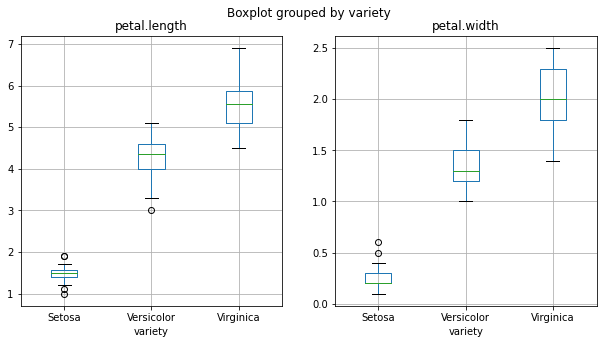

In [4]:
# Plot petal length/width by iris type
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
df.boxplot("petal.length", "variety", ax=ax[0])
df.boxplot("petal.width", "variety", ax=ax[1])
plt.show()

Overall, we observe noticeable differences between iris types, especially between Setosa and Virginica. Let's quantify differences between the two types.

In [5]:
# Calculate averages for Setosa
avg_length_setosa = df.query("variety == 'Setosa'")["petal.length"].mean()
avg_width_setosa = df.query("variety == 'Setosa'")["petal.width"].mean()

# Calculate averages for Virginica
avg_length_virginica = df.query("variety == 'Virginica'")["petal.length"].mean()
avg_width_virginica = df.query("variety == 'Virginica'")["petal.width"].mean()

# Calculate differences
diff_avg_length = avg_length_setosa - avg_length_virginica
diff_avg_width = avg_width_setosa - avg_width_virginica

In [6]:
# NBVAL_IGNORE_OUTPUT

# View result
print("Difference in average length:", diff_avg_length)
print("Difference in average width:", diff_avg_width)

Difference in average length: -4.09
Difference in average width: -1.7800000000000002


## Storing an artifact with `save()`

Say we are particularly interested in tracking the average length difference between Setosa and Virginica. For instance, we might want to use this variable later for population-level modeling of the two species.

The `save()` method allows us to store a variable's value *and* history as a data type called `LineaArtifact`. Note that `LineaArtifact` holds more than the final state of the variable &mdash; it also captures the complete development process behind the variable, which allows for full reproducibility. For more information about artifacts in LineaPy, please check the [Concepts](https://docs.lineapy.org/en/latest/concepts/artifact.html) section.

The method requires two arguments: the variable to save and the string name to save it as. It returns the saved artifact.

In [7]:
# NBVAL_IGNORE_OUTPUT

# Store the variable as an artifact
length_artifact = lineapy.save(diff_avg_length, "iris_diff_avg_length")

# Check object type
print(type(length_artifact))

<class 'lineapy.api.models.linea_artifact.LineaArtifact'>


`LineaArtifact` object has two key APIs:

- `.get_value()` returns value of the artifact, e.g., an integer or a dataframe
- `.get_code()` returns minimal essential code to create the value

Hence, for the current artifacts, we see:

In [8]:
# Check the value of the artifact
print(length_artifact.get_value())

-4.09


<div class="alert alert-info">

☝️ ☝️ ☝️ **[FEATURE] Retrieve artifact value** ☝️ ☝️ ☝️

</div>

In [9]:
# Check minimal essential code to generate the artifact
print(length_artifact.get_code())

import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv"
)
avg_length_setosa = df.query("variety == 'Setosa'")["petal.length"].mean()
avg_length_virginica = df.query("variety == 'Virginica'")["petal.length"].mean()
diff_avg_length = avg_length_setosa - avg_length_virginica



<div class="alert alert-info">

☝️ ☝️ ☝️ **[FEATURE] Retrieve cleaned artifact code** ☝️ ☝️ ☝️

</div>

Note that irrelevant code has been stripped out (e.g., operations relating to `diff_avg_width` only).

<div class="alert alert-info">

**Note:** If you want, you can retrieve the artifact's full original code with `artifact.get_session_code()`.

</div>

## Listing artifacts with `artifact_store()`

Of course, with time passing, we may not remember what artifacts we saved and under what names. The `artifact_store()` method allows us to see the list of all previously saved artifacts, like so:

In [10]:
# NBVAL_IGNORE_OUTPUT

# List all saved artifacts
lineapy.artifact_store()

iris_diff_avg_length:0 created on 2022-09-25 22:20:07.542825

<div class="alert alert-info">

☝️ ☝️ ☝️ **[FEATURE] Retrieve all artifacts** ☝️ ☝️ ☝️

</div>

Note that the artifact store records each artifact’s creation time, which means that multiple versions can be stored under the same artifact name. Hence, if we save `iris_diff_avg_length` artifact again, we get:


In [11]:
# NBVAL_IGNORE_OUTPUT

# Save the same artifact again
lineapy.save(diff_avg_length, "iris_diff_avg_length")

# List all saved artifacts
lineapy.artifact_store()

iris_diff_avg_length:0 created on 2022-09-25 22:20:07.542825
iris_diff_avg_length:1 created on 2022-09-25 22:20:07.690403

## Retrieving an artifact with `get()`

We can retrieve any stored artifact using the `get()` method. This comes in handy when we work across multiple sessions/phases of a project (or even across different projects) as we can easily build on the previous work.

For example, say we have done other exploratory analyses and are finally starting our work on population-level modeling. This is likely done in a new Jupyter notebook (possibly in a different subdirectory) and we need an easy way to load artifacts from our past work. We can use the `get()` method for this.

The method takes the string name of the artifact as its argument and returns the corresponding artifact, like so:

In [12]:
# Retrieve a saved artifact
length_artifact2 = lineapy.get("iris_diff_avg_length")

# Confirm the artifact holds the same value and code as before
print(length_artifact2.get_value())
print(length_artifact2.get_code())

-4.09
import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/LineaLabs/lineapy/main/examples/tutorials/data/iris.csv"
)
avg_length_setosa = df.query("variety == 'Setosa'")["petal.length"].mean()
avg_length_virginica = df.query("variety == 'Virginica'")["petal.length"].mean()
diff_avg_length = avg_length_setosa - avg_length_virginica



By default, the `get()` method retrieves the latest version of the given artifact. To retrieve a particular version of the artifact, we can specify the value of the optional argument `version`, like so:

In [13]:
# NBVAL_IGNORE_OUTPUT

# Get version info of the retrieved artifact
desired_version = length_artifact2.version

# Check the version info
print(desired_version)
print(type(desired_version))

1
<class 'int'>


In [14]:
# NBVAL_IGNORE_OUTPUT

# Retrieve the same version of the artifact
length_artifact3 = lineapy.get("iris_diff_avg_length", version=desired_version)

# Confirm the right version has been retrieved
print(length_artifact3.name)
print(length_artifact3.version)

iris_diff_avg_length
1


## Deleting an artifact with `delete()`

With time passing, it is likely that the artifact store contains many artifacts, including some that we no longer need/want. We can use the `delete()` API to remove such undesired artifacts. For instance, we currently have two versions of `iris_diff_avg_length` artifact, like so:

In [15]:
# NBVAL_IGNORE_OUTPUT

# List all saved artifacts
lineapy.artifact_store()

iris_diff_avg_length:0 created on 2022-09-25 22:20:07.542825
iris_diff_avg_length:1 created on 2022-09-25 22:20:07.690403

Let's say we no longer need version `1`. We can remove it by calling the `delete()` API with the artifact name and version, as the following:

In [16]:
# NBVAL_IGNORE_OUTPUT

# Delete a specific artifact
lineapy.delete("iris_diff_avg_length", version=1)

Deleted Artifact: iris_diff_avg_length version: 1                                                                                                                                                            


If we check the artifact store again, we no longer see the artifact:

In [17]:
# NBVAL_IGNORE_OUTPUT

# List all saved artifacts
lineapy.artifact_store()

iris_diff_avg_length:0 created on 2022-09-25 22:20:07.542825

Note that we can also pass a string value to `version`:
- `version="latest"` will delete the latest version of the artifact
- `version="all"` will delete all versions of the artifact

## Recap

In this tutorial, we learned basic functionalities of LineaPy including how to save, browse, retrieve, and delete an artifact. We saw that a LineaPy artifact stores not only the value of a variable but also its full development code. This then enables automation of time-consuming, manual steps in a data science workflow such as code cleanup and pipeline building (check the relevant tutorial [here](https://docs.lineapy.org/en/latest/tutorials/02_pipeline_building.html)), hence helping data scientists move faster towards productionization and impact.

<div class="alert alert-info">

If you want to learn more about how LineaPy artifacts can help your work, check out the project [documentation](https://docs.lineapy.org/en/latest/guides/using-artifacts/index.html).

</div>